# Ce notebook explore la comparaison de gros documents avec le pipeline de RAG

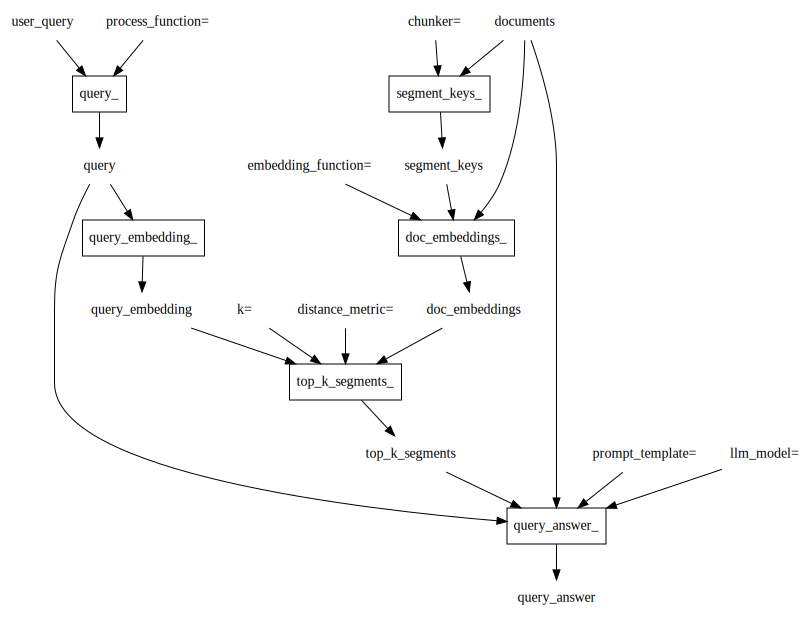

In [4]:
from raglab.retrieval.lib_alexis import dag
dag.dot_digraph()

Création d'un store sur les fichiers de contracts

In [5]:
from i2 import Namespace
from dol import Files
from raglab.retrieval.lib_alexis import extension_base_wrap
folder_path = "/Users/alexis/Documents/GitHub/rag_sante/contracts/"

mall = Namespace(contracts = extension_base_wrap(Files(folder_path)))

In [6]:
# tous les contracts dans le dossier
list(mall.contracts)

['240402 Axeptio X ADDIX GROUP - Conditions generales de partenariat anglais francais 050424[228731].pdf',
 'Contrat + Bons de commande-Antoine NASSIF + Pierre TCHEKOUTEU-301223.pdf',
 'Contrat AddixWare GreenCom Networks_V2.pdf',
 'Contrat PSI_ADDIXWARE (Mathilde Chenillot) (1).pdf',
 'Contrat d_assistance technique-Axeptio-ADW [60][228732].pdf',
 'Contrat_ONE140623_Dvlpmt UO & KPI Pilotage Site SAFRAN Châtellerault_2023 07 21 (signed).pdf',
 'Avenant Contrat AddixWare GreenCom Networks_V2.pdf',
 'Annexe 3 CP - Schneider 2021 - V2.pdf']

création d'un mapping pour les documents (à stocker dans un DB)

In [7]:
documents = dict(mall.contracts)

Sélection de 2 contracts

In [33]:
selection  = ["240402 Axeptio X ADDIX GROUP - Conditions generales de partenariat anglais francais 050424[228731].pdf", "Contrat PSI_ADDIXWARE (Mathilde Chenillot) (1).pdf"]
# select 2 files with a file chooser
file1 = selection[0]
file2 = selection[1]

dict1 = {file1: mall.contracts[file1]}
dict2 = {file2: mall.contracts[file2]}

embeddings_1 = dag[:"doc_embeddings"](dict1)
embeddings_2 = dag[:"doc_embeddings"](dict2)

Créations d'une corresponce par clés des segments à comparer

In [38]:
def comparison_mapping(doc1_embedding, doc2_embedding):
    to_compare_list = []
    for key, value in doc1_embedding.items():
        key_to_compare = dag["query_embedding":"top_k_segments"](query_embedding = value, k = 3, doc_embeddings = doc2_embedding)
        to_compare_list.append( key_to_compare)
    return zip(doc1_embedding.keys(), to_compare_list) # tuples : (key of doc1, list of keys of doc2 to compare)
    

comparaisons

In [40]:
from raglab.retrieval.lib_alexis import query_answer
from tqdm import tqdm
from typing import Callable
# comparison segment by segment
def segments_comparison(doc1_embedding,doc2_embedding, mapping_func: Callable)->str:
    """ Compare each segment of doc1 with the mapped segments of doc2 and gather the comparisons in a string 
    Args:
        doc1_embedding : dict
            dictionary of embeddings of doc1
        doc2_embedding : dict
            dictionary of embeddings of doc2
        mapping_func : Callable
            function that maps segments of doc1 to segments of doc2 in a zip of tuples
    Returns:
        comparison_txt : str
            string of comparisons
    """
    comparison_txt = ""
    mapping = mapping_func(doc1_embedding, doc2_embedding)
    for id1, list_id2 in tqdm(mapping):
        comparison = query_answer(query=dict1[id1[0]][id1[1]:id1[2]], # doc 1 as query
                                documents=dict2,
                                top_k_segments=list_id2,
                                prompt_template="compare le document 1: {query} avec le document2 : {documents} en francais"
        )
        comparison_txt += comparison + "\n"
    return comparison_txt

# aggregation of all comparisons
def parsed_comparison(segments_comparison: str)->str:
    from oa import prompt_function
    template = "Je vais te donner des comparaisons entre des documents. Tu doit mettre en forme et réécrire toutes les comparaisons faites en évitant les répétitions. Voici les comparaisons entre 2 documents: {comparaisons}"
    f = prompt_function(template)
    return f(comparaisons=segments_comparison)


print(parsed_comparison(segments_comparison(embeddings_1, embeddings_2, comparison_mapping)))

# with open("comparaisons.txt", "w") as f:
#   for comparison in comparaisons:
#     f.write(comparison)
#     f.write("\n\n")

10it [02:32, 15.21s/it]


En résumé, les deux documents partagent des similitudes dans la mesure où ils abordent les obligations et les engagements des parties dans le cadre d'un contrat de prestation de services. Ils mettent également l'accent sur la protection des données personnelles et les conditions de résiliation du contrat en cas de manquement. Cependant, le document 1 est plus général et inclut des clauses sur la confidentialité, la fiscalité, la sécurité des données et la gestion du personnel, tandis que le document 2 est plus spécifique et traite des conditions relatives à la sous-traitance et au traitement des données personnelles. À travers une approche complémentaire, ces documents s'associent pour former un cadre contractuel complet pour garantir le respect des obligations contractuelles et légales entre les parties impliquées.


## Essai de pipeline RAG sur les contracts pour le question/reponse

In [14]:
responce = dag[:"top_k_segments"](documents=documents, user_query="quel est la reglementation pour les déjeunés en entreprise. Où doivent s'effectuer les repas?", k=1)
responce = responce[0]
print(documents[responce[0]][responce[1]:responce[2]])